# PREDICCIÓN DE PITCHES

## NOTA IMPORTANTE. No me ha dejado subir el zip con los csv con los datos porque superan el limite de 20 MB. Si quieres ejecutar este cuaderno dimelo y te subo los datos a un Drive.

#### Cargamos los datos y unimos los 3 dataframes

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pitches= pd.read_csv('pitches.csv')
atbats= pd.read_csv('atbats.csv')
player_name= pd.read_csv('player_names.csv')
pitches['ab_id'] = pitches['ab_id'].astype(int)
player_name.rename(columns={'id': 'batter_id'}, inplace=True)
data=pd.merge(pitches, atbats,  how='left', left_on='ab_id', right_on = 'ab_id')
data=pd.merge(data, player_name,  how='left', left_on='batter_id', right_on = 'batter_id')
data['Batters Name'] = data[['first_name', 'last_name']].apply(lambda x: ' '.join(x), axis=1)
data=data.drop(['first_name','last_name','code'],axis=1)
data=data.dropna() #Quitar nulos
data.head()



,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,...,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top,Batters Name
0,0.416,2.963,92.9,84.1,2305.052,159.235,-25.0,3.2,23.7,7.665,...,Groundout,201500001,1,1,0,L,452657,L,True,Matt Carpenter
1,-0.191,2.347,92.8,84.1,2689.935,151.402,-40.7,3.4,23.7,12.043,...,Groundout,201500001,1,1,0,L,452657,L,True,Matt Carpenter
2,-0.518,3.284,94.1,85.2,2647.972,145.125,-43.7,3.7,23.7,14.368,...,Groundout,201500001,1,1,0,L,452657,L,True,Matt Carpenter
3,-0.641,1.221,91.0,84.0,1289.590,169.751,-1.3,5.0,23.8,2.104,...,Groundout,201500001,1,1,0,L,452657,L,True,Matt Carpenter
4,-1.821,2.083,75.4,69.6,1374.569,280.671,18.4,12.0,23.8,-10.280,...,Groundout,201500001,1,1,0,L,452657,L,True,Matt Carpenter


### Quitamos las columnas que no nos interesan y los tipos de pitches algo menos comunes que no son objeto de estudio

In [11]:
data=data.drop(['type','on_1b','on_2b','on_3b','pitch_num','outs','b_score','event_num','batter_id','p_score','p_throws','Batters Name','stand','inning','top','type_confidence','ab_id','o','pitcher_id','event','g_id','b_count','s_count','sz_bot','sz_top','px','pz'],axis=1)
data = data.drop(index=data[data["pitch_type"] == "AB"].index)
data = data.drop(index=data[data["pitch_type"] == "FA"].index)
data = data.drop(index=data[data["pitch_type"] == "UN"].index)
data = data.drop(index=data[data["pitch_type"] == "SC"].index)
data = data.drop(index=data[data["pitch_type"] == "PO"].index)
data = data.drop(index=data[data["pitch_type"] == "FO"].index)
data = data.drop(index=data[data["pitch_type"] == "EP"].index)
data = data.drop(index=data[data["pitch_type"] == "IN"].index)
data = data.drop(index=data[data["pitch_type"] == "KC"].index)
data = data.drop(index=data[data["pitch_type"] == "FS"].index)
data = data.drop(index=data[data["pitch_type"] == "KN"].index)
data = data.drop(index=data[data["pitch_type"] == "FT"].index)
data = data.drop(index=data[data["pitch_type"] == "SI"].index)



### Seleccionamos las primeras 300000 filas y separamos la variable target (y) de los datos (X)

In [12]:
data=data[0:300000]
X=data.drop(['pitch_type'],axis=1) 
y=data["pitch_type"]
columns=X.columns


### Vemos cuantas filas y columnas tenemos ahora y los nombres de las columnas

In [13]:
print(len(data.columns))
print(len(data))
print(columns)


23
300000
Index(['start_speed', 'end_speed', 'spin_rate', 'spin_dir', 'break_angle',
       'break_length', 'break_y', 'ax', 'ay', 'az', 'vx0', 'vy0', 'vz0', 'x',
       'x0', 'y', 'y0', 'z0', 'pfx_x', 'pfx_z', 'nasty', 'zone'],
      dtype='object')


### Separamos columnas categoricas de numericas. No habra categoricas

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# One-hot-encoding of the categoric variables
# ------------------------------------------------------------------------------
# Identification of categoric and numerical variables/column
cat_cols = X.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.to_list()
cat_cols

[]

### Escalamos las columnas respecto al Minimo y al Maximo

In [15]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler() #feature_range=(0, 2) insise parenthesis if a different scale is needed
names = X.columns  # collecting names of columns
d = scaler.fit_transform(X)  # transforming X to normalized
X_norm = pd.DataFrame(d, columns=names) # creation of Xframe normalized 
X_norm.head()
#X_denorm=scaler.inverse_transform(X) Denormalizar variables

,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,ay,az,...,vz0,x,x0,y,y0,z0,pfx_x,pfx_z,nasty,zone
0,0.819588,0.787992,0.507389,0.442325,0.180575,0.106061,0.375,0.649140,0.670950,0.674595,...,0.491971,0.405257,0.736103,0.635145,0.0,0.337485,0.594686,0.738349,0.521277,0.153846
1,0.817869,0.787992,0.592154,0.420567,0.136757,0.113636,0.375,0.725262,0.660507,0.704206,...,0.423718,0.497977,0.722884,0.701668,0.0,0.338244,0.662804,0.765451,0.265957,0.307692
2,0.840206,0.808630,0.582912,0.403131,0.128384,0.125000,0.375,0.765688,0.684366,0.680912,...,0.514596,0.547902,0.723541,0.600464,0.0,0.339156,0.692199,0.737082,0.457447,0.000000
3,0.786942,0.786116,0.283747,0.471536,0.246721,0.174242,0.500,0.552449,0.527230,0.539094,...,0.403535,0.439498,0.736021,0.749884,0.0,0.323512,0.510175,0.624873,0.372340,0.923077
4,0.518900,0.515947,0.302463,0.779647,0.301702,0.439394,0.500,0.337124,0.377857,0.324774,...,0.640512,0.587120,0.727810,0.709000,0.0,0.376215,0.238836,0.419706,0.127660,0.923077


### Codificamos los tipos de pitches en números del 1 al 5

In [16]:
from sklearn.preprocessing import LabelEncoder
# create an instance of LabelEncoder
le = LabelEncoder()
# fit and transform the classes into encoded numbers
encoded_classes = le.fit_transform(y.unique())

In [17]:
# Define a dictionary to map the categories to numbers
cat_to_num = {'FF': 1, 'SL': 2, 'CH': 3,'CU' : 4, 'FC' : 5}

# Map the categorical values to the corresponding numbers
y= y.replace(cat_to_num)

### Dividimos los datos, un 80% para entrenamiento y un 20 % para test

In [18]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
                                        X_norm,
                                        y,
                                        train_size   = 0.80,  # 80% for training
                                        random_state = 1233,
                                        shuffle      = True
                                    )
X_train.head()

,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,ay,az,...,vz0,x,x0,y,y0,z0,pfx_x,pfx_z,nasty,zone
16748,0.795533,0.810507,0.490236,0.537739,0.292771,0.106061,0.625,0.432007,0.450478,0.670552,...,0.314857,0.477341,0.388948,0.786551,0.0,0.423603,0.403053,0.735562,0.361702,0.923077
29741,0.673540,0.669794,0.089609,0.117100,0.233324,0.340909,0.500,0.556431,0.490840,0.314667,...,0.554998,0.387707,0.323508,0.761510,0.0,0.386391,0.520068,0.417680,0.404255,0.615385
51485,0.817869,0.812383,0.506099,0.636469,0.357801,0.185606,0.500,0.232521,0.567638,0.578070,...,0.475054,0.562127,0.427047,0.627785,0.0,0.437120,0.230921,0.651469,0.478723,0.000000
239130,0.823024,0.816135,0.436167,0.639122,0.336869,0.193182,0.500,0.267557,0.586888,0.544053,...,0.403294,0.534479,0.417522,0.778471,0.0,0.364976,0.261730,0.621834,0.436170,0.461538
148454,0.785223,0.769231,0.488226,0.427914,0.183645,0.132576,0.375,0.670475,0.584300,0.643862,...,0.378228,0.679288,0.661959,0.777391,0.0,0.361179,0.618994,0.721631,0.276596,0.923077


In [19]:
print(len(X_train))
print(len(X_test))

240000
60000


### Comprobamos cuantos pitches hay por tipo

In [20]:
y_train.value_counts()

1    115223
2     46963
3     34759
4     23916
5     19139
Name: pitch_type, dtype: int64

### Aplicamos NearMiss para hacer undersampling y vemos cuantas hay de cada clase ahora

In [21]:
from imblearn.under_sampling import NearMiss
nr = NearMiss()
X_train_res_arr, y_train_res_arr = nr.fit_resample(X_train, y_train.ravel())

In [22]:
y_train_res=pd.DataFrame(y_train_res_arr)
X_train_res=pd.DataFrame(X_train_res_arr,columns=columns)
print(y_train_res.value_counts())


1    19139
2    19139
3    19139
4    19139
5    19139
dtype: int64


## ARBOL DE DECISIÓN

In [217]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
# Grid Search
param_grid = {
    'max_depth':[5,10,20,None],
    'min_samples_split':[20,40,60,80],
    'min_impurity_decrease': [0.0001, 0.0005, 0.001],
    'criterion' :['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2']
}
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=10, n_jobs=1)
gridSearch.fit(X_train_res, y_train_res)
print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)

Initial score:  0.7962631414593525
Initial parameters:  {'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'min_impurity_decrease': 0.0001, 'min_samples_split': 40}


In [23]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion='entropy',max_depth=None, max_features='auto', min_impurity_decrease=0.0001, min_samples_split= 40,random_state = 15)
model.fit(X_train_res, y_train_res)
predicted = model.predict(X_test)

In [19]:
importance_predictors = pd.DataFrame(
                            {'predictor': X_train_res.columns,
                             'importance': model.feature_importances_}
                            )
print("Importance  of the model predictors")
print("-------------------------------------------")
importance_predictors.sort_values('importance', ascending=False)

Importance  of the model predictors
-------------------------------------------


,predictor,importance
19,pfx_z,0.187409
11,vy0,0.146709
12,vz0,0.114867
5,break_length,0.112115
9,az,0.099370
18,pfx_x,0.067551
7,ax,0.047585
4,break_angle,0.041471
3,spin_dir,0.036695
2,spin_rate,0.032722


Accuracy of Decision Tree classifier on training set: 0.8292
Accuracy of Decision Tree classifier on test set: 0.7696


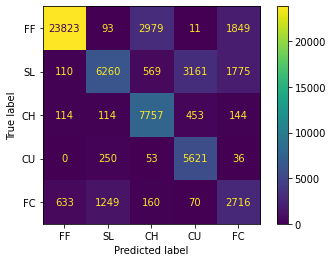

In [24]:
from sklearn import metrics  
predicted=model.predict(X_test) 
print('Accuracy of Decision Tree classifier on training set: {:.4f}'
     .format(model.score(X_train_res, y_train_res)))
print('Accuracy of Decision Tree classifier on test set: {:.4f}'
     .format(model.score(X_test, y_test)))
confusion_matrix = metrics.confusion_matrix(y_test, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['FF','SL','CH','CU','FC'])
cm_display.plot()
plt.show()

## KNN NEIGHBORS

C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

29

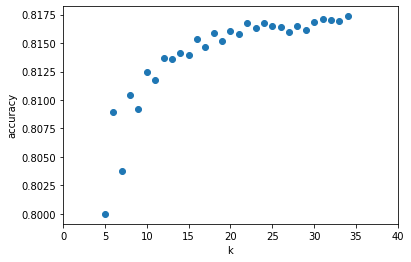

In [216]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# SDelection of optimum K
k_range = range(5, 35)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_res, y_train_res)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20, 25, 30, 35, 40])

scores.index(max(scores))

C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy of K-NN classifier on training set: 0.8364
Accuracy of K-NN classifier on test set: 0.8119


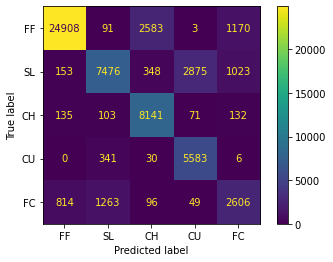

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Training
n_neighbors = 34 # Especificar numero vecinos
knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train_res, y_train_res)
print('Accuracy of K-NN classifier on training set: {:.4f}'
     .format(knn.score(X_train_res, y_train_res)))
print('Accuracy of K-NN classifier on test set: {:.4f}'
     .format(knn.score(X_test, y_test)))

#Testing

pred = knn.predict(X_test)
confusion_matrix = metrics.confusion_matrix(y_test, pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['FF','SL','CH','CU','FC'])
cm_display.plot()
plt.show()

## RANDOM FOREST

In [175]:
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestClassifier
param_grid = {'n_estimators': [50, 100, 150],
              'max_features': ["sqrt","log2",None],
              'max_depth'   : [None, 3, 10, 20],
              'criterion'   : ['gini', 'entropy']
             }

# grid search by CV
# ==============================================================================
grid = GridSearchCV(
        estimator  = RandomForestClassifier(random_state = 123),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train_res, y = y_train_res)

# Resultados
# ==============================================================================
results_cv = pd.DataFrame(grid.cv_results_)
results_cv.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)
print(grid.best_params_, ":", grid.best_score_, grid.scoring)
model_final = grid.best_estimator_


C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'n_estimators': 150} : 0.8567706755528626 accuracy


In [ ]:
from sklearn import metrics  
from sklearn.ensemble import RandomForestClassifier
model_final = RandomForestClassifier(criterion='entropy',max_depth=None,max_features=None, n_estimators=150) 
model_final.fit(X = X_train_res, y = y_train_res)


In [22]:
importance_predictors = pd.DataFrame(
                            {'predictor': X_train_res.columns,
                             'importance': model_final.feature_importances_}
                            )
print("Importance  of the model predictors")
print("-------------------------------------------")
importance_predictors.sort_values('importance', ascending=False)

Importance  of the model predictors
-------------------------------------------


,predictor,importance
5,break_length,0.453496
2,spin_rate,0.095497
14,x0,0.070542
18,pfx_x,0.068660
11,vy0,0.037969
17,z0,0.034792
7,ax,0.031962
4,break_angle,0.025834
10,vx0,0.023877
20,nasty,0.020073


Accuracy of RF classifier on training set: 1.0000
Accuracy of RF classifier on test set: 0.8042


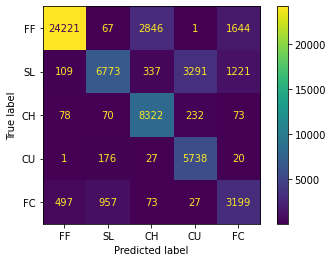

In [27]:
predicted=model_final.predict(X_test) 
print('Accuracy of RF classifier on training set: {:.4f}'
     .format(model_final.score(X_train_res, y_train_res)))
print('Accuracy of RF classifier on test set: {:.4f}'
     .format(model_final.score(X_test, y_test)))
confusion_matrix = metrics.confusion_matrix(y_test, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['FF','SL','CH','CU','FC'])
cm_display.plot()
plt.show()

## MULTILAYER PERCEPTRON

In [ ]:
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV
mlp_clf = MLPClassifier(max_iter=300)

param_grid = {
    'hidden_layer_sizes': [(10,30,10), (40,40), (15,25,15),(20,20)],
    'activation': ['relu','tanh','logistic'],
    'solver': ['adam'],
    'learning_rate_init': [0.001,0.05,0.01],
}
grid = GridSearchCV(mlp_clf, param_grid, n_jobs= -1, cv=5)
grid.fit(X_train_res, y_train_res)
print(grid.best_params_)


Accuracy in TRAINING: 0.8517
Accuracy in TEST: 0.8250


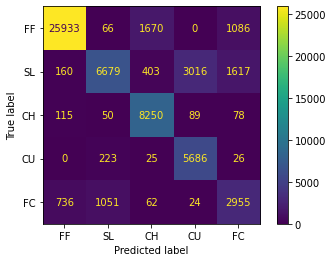

In [38]:
mlp_clf_final = MLPClassifier(max_iter=300,activation='tanh',hidden_layer_sizes=(40, 40),learning_rate_init=0.001,solver='adam')
mlp_clf_final.fit(X_train_res, y_train_res)
prediction_train= mlp_clf_final.predict(X_train_res)
print('Accuracy in TRAINING: {:.4f}'.format(accuracy_score(y_train_res, prediction_train)))
# Evaluation TRST 
prediction_test= mlp_clf_final.predict(X_test)
print('Accuracy in TEST: {:.4f}'.format(accuracy_score(y_test, prediction_test)))
confusion_matrix = metrics.confusion_matrix(y_test, prediction_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['FF','SL','CH','CU','FC'])
cm_display.plot()
plt.show()